# 1 - Import & paths

In [1]:
# Core imports for EDA
from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow

# Project paths (adjust if your notebook path differs)
ROOT = Path("..")  # this notebook is in notebooks/, so .. is project root
DATA = ROOT / "data"
SILVER = DATA / "silver" / "jobs_text.parquet"
GOLD = DATA / "gold"

# Basic display prefs
pl.Config.set_fmt_str_lengths(120)
pd.set_option("display.max_colwidth", 120)

# 2 - Load a manageable slice

In [2]:
# Lazy scan to avoid loading entire file; then collect a sample for quick EDA
lf = pl.scan_parquet(SILVER)

# Peek schema and row count cheaply
print("Columns:", lf.collect_schema().names())

# If the file is big, start with a sample to iterate faster
SAMPLE_N = 100_000
df = lf.head(SAMPLE_N).collect()

df.head(5)

Columns: ['title_lc', 'company', 'location', 'seniority', 'work_type', 'posted_at', 'skills_list', 'text']


title_lc,company,location,seniority,work_type,posted_at,skills_list,text
str,str,str,str,str,datetime[μs],list[str],str
"""senior software engineer - backend""","""Walmart""","""Reston, VA""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""senior software engineer - backend """
"""lead software engineer, back end""","""ClickJobs.io""","""Poughkeepsie, NY""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""lead software engineer, back end """
"""asset & wealth management- senior software engineer, multi asset solutions digital advice platform- new york- vice presi…","""Goldman Sachs""","""New York, NY""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""asset & wealth management- senior software engineer, multi asset solutions digital advice platform- new york- vice presi…"
"""senior software engineer, devops""","""Jobs for Humanity""","""Atlantic City, NJ""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""senior software engineer, devops """
"""principal software engineer, ml accelerators""","""Aurora""","""San Francisco, CA""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""principal software engineer, ml accelerators """


# 3 - Quick health checks 

In [3]:
print("Shape:", df.shape)
df_nulls = df.select(
    [
        *(pl.col(c).is_null().sum().alias(f"{c}_nulls") for c in df.columns),
        pl.count().alias("total_rows"),
    ]
)
df_nulls

Shape: (13420, 8)


/var/folders/pf/h7_448690wbc1y9r5lpp7vv80000gn/T/ipykernel_85125/1677090054.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_rows"),


title_lc_nulls,company_nulls,location_nulls,seniority_nulls,work_type_nulls,posted_at_nulls,skills_list_nulls,text_nulls,total_rows
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,13420


# 4 — Distributions: roles (title keywords), work_type, seniority

In [4]:
# Role buckets by keyword; adjust if needed
ROLE_PATTERNS = {
    "data scientist": r"\bdata scientist\b",
    "data analyst": r"\bdata analyst\b",
    "data engineer": r"\bdata engineer\b",
    "software engineer": r"\bsoftware engineer\b",
}

role_counts = []
for role, pat in ROLE_PATTERNS.items():
    cnt = df.filter(pl.col("title_lc").str.contains(pat)).height
    role_counts.append((role, cnt))

role_counts = pd.DataFrame(role_counts, columns=["role", "count"]).sort_values(
    "count", ascending=False
)
role_counts

,role,count
3,software engineer,9119
1,data analyst,1922
2,data engineer,1523
0,data scientist,864


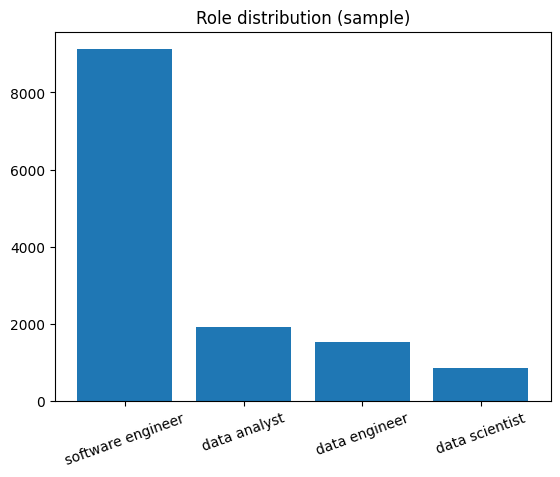

In [5]:
# Plot role distribution (matplotlib)
plt.figure()
plt.bar(role_counts["role"], role_counts["count"])
plt.xticks(rotation=20)
plt.title("Role distribution (sample)")
plt.show()

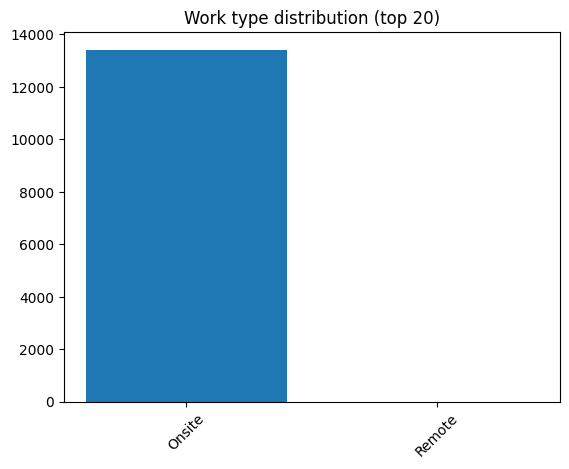

In [6]:
work_type_counts = (
    df.with_columns(pl.col("work_type").fill_null("NA"))
    .group_by("work_type")
    .agg(pl.len().alias("count"))  # 👈 用 pl.len()
    .sort("count", descending=True)
    .head(20)
)

x = work_type_counts["work_type"].to_list()
y = work_type_counts["count"].to_list()

plt.figure()
plt.bar(x, y)
plt.xticks(rotation=45)
plt.title("Work type distribution (top 20)")
plt.show()

# 5 — Top locations & companies

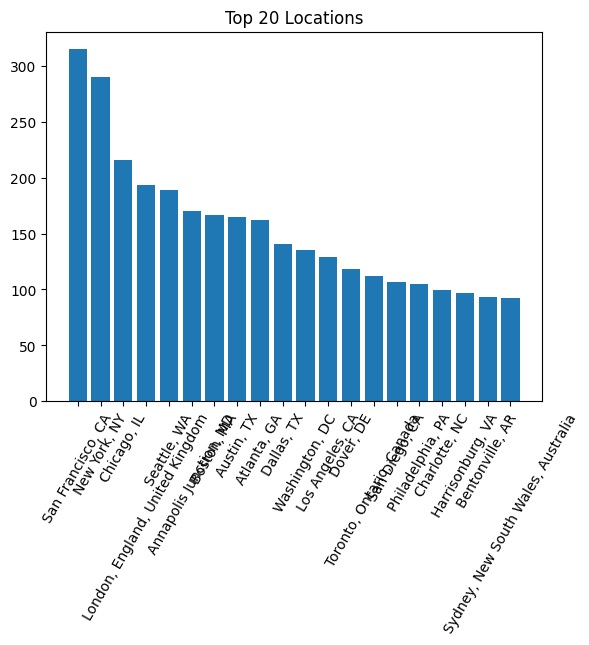

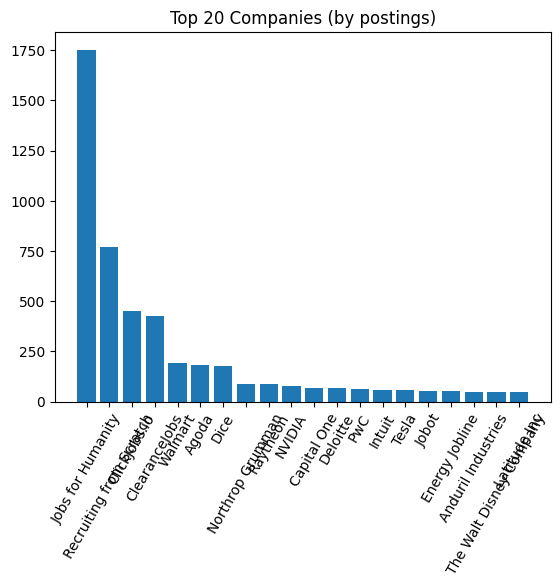

In [7]:
# Top locations
loc_counts = (
    df.with_columns(pl.col("location").fill_null("NA"))
    .group_by("location")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(20)
    .to_pandas()
)
plt.figure()
plt.bar(loc_counts["location"], loc_counts["count"])
plt.xticks(rotation=60)
plt.title("Top 20 Locations")
plt.show()

# Top companies
comp_counts = (
    df.with_columns(pl.col("company").fill_null("NA"))
    .group_by("company")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(20)
    .to_pandas()
)
plt.figure()
plt.bar(comp_counts["company"], comp_counts["count"])
plt.xticks(rotation=60)
plt.title("Top 20 Companies (by postings)")
plt.show()

# 6 — Time series (posting trend by month)

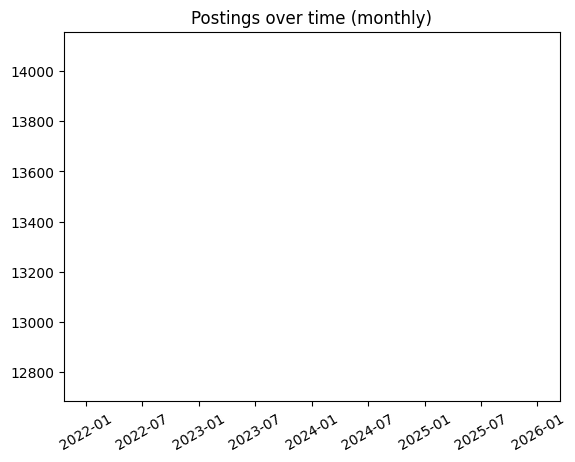

In [8]:
ts = (
    df.with_columns(pl.col("posted_at").dt.truncate("1mo").alias("posted_month"))
    .drop_nulls("posted_month")
    .group_by("posted_month")
    .agg(pl.len().alias("count"))
    .sort("posted_month")
)
plt.figure()
plt.plot(ts["posted_month"].to_list(), ts["count"].to_list())
plt.xticks(rotation=30)
plt.title("Postings over time (monthly)")
plt.show()

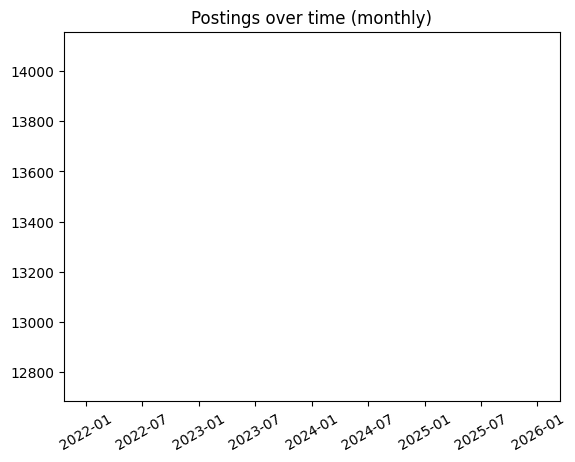

In [9]:
# Ensure posted_at is datetime; group by month
ts = (
    df.with_columns(
        [pl.col("posted_at").cast(pl.Datetime).dt.truncate("1mo").alias("posted_month")]
    )
    .drop_nulls("posted_month")
    .group_by("posted_month")
    .agg(pl.len().alias("count"))
    .sort("posted_month")
    .to_pandas()
)

plt.figure()
plt.plot(ts["posted_month"], ts["count"])
plt.xticks(rotation=30)
plt.title("Postings over time (monthly)")
plt.show()

# 7 — Top skills overall

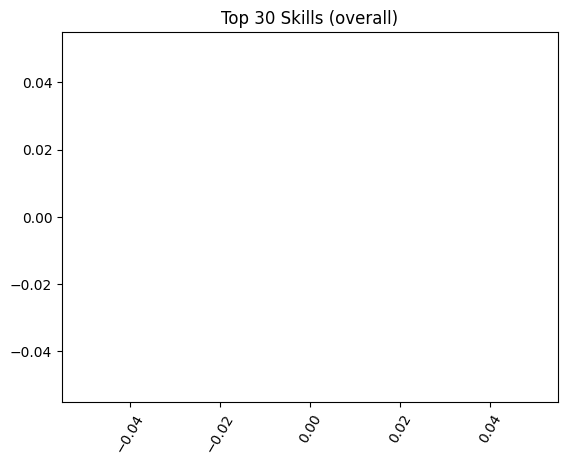

,skills_list,count


In [10]:
top_skills = (
    df.explode("skills_list")
    .drop_nulls("skills_list")
    .group_by("skills_list")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(30)
    .to_pandas()
)

plt.figure()
plt.bar(top_skills["skills_list"], top_skills["count"])
plt.xticks(rotation=60)
plt.title("Top 30 Skills (overall)")
plt.show()

top_skills.head(15)

# 8 — Top skills per role (example for one role)

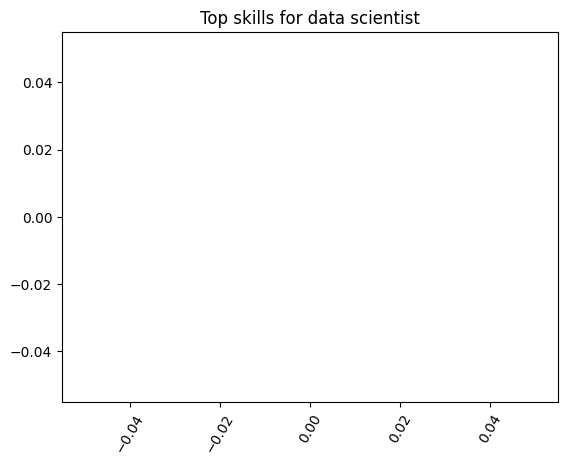

,skills_list,count


In [11]:
def top_skills_for_role(
    pdf: pl.DataFrame, role_regex: str, topk: int = 20
) -> pd.DataFrame:
    tmp = (
        pdf.filter(pl.col("title_lc").str.contains(role_regex))
        .explode("skills_list")
        .drop_nulls("skills_list")
        .group_by("skills_list")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(topk)
    )
    return tmp.to_pandas()


role = "data scientist"
pat = r"\bdata scientist\b"
top_role_skills = top_skills_for_role(df, pat, topk=20)
plt.figure()
plt.bar(top_role_skills["skills_list"], top_role_skills["count"])
plt.xticks(rotation=60)
plt.title(f"Top skills for {role}")
plt.show()

top_role_skills.head(10)

# 9 — Skill co-occurrence (lightweight)

In [12]:
# Build a simple co-occurrence count for top N skills
TOPN = 20
topN = (
    df.explode("skills_list")
    .drop_nulls("skills_list")
    .group_by("skills_list")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(TOPN)
    .select("skills_list")
    .to_series()
    .to_list()
)

# Create pairs within each posting, restricted to topN
pairs = (
    df.select("skills_list")
    .drop_nulls("skills_list")
    .with_columns(
        [
            pl.col("skills_list")
            .list.eval(pl.element().filter(pl.element().is_in(topN)))
            .alias("top_sk")
        ]
    )
    .select("top_sk")
    .filter(pl.col("top_sk").list.len() >= 2)
    .with_columns(pl.col("top_sk").list.unique())
    .select(pl.col("top_sk").list.combinations(2).alias("pairs"))
    .explode("pairs")
    .select(
        [
            pl.col("pairs").arr.get(0).alias("s1"),
            pl.col("pairs").arr.get(1).alias("s2"),
        ]
    )
    .group_by(["s1", "s2"])
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .to_pandas()
)

pairs.head(10)

AttributeError: 'ExprListNameSpace' object has no attribute 'combinations'

# 10 — Save EDA artifacts

In [ ]:
# GOLD.mkdir(parents=True, exist_ok=True)

# # Save tables you might reuse in 02_clusters or report
# pl.DataFrame(top_skills).write_parquet(GOLD / "eda_top_skills.parquet")
# pl.DataFrame(role_counts).write_parquet(GOLD / "eda_role_counts.parquet")
# pl.DataFrame(comp_counts).write_parquet(GOLD / "eda_top_companies.parquet")
# pl.DataFrame(loc_counts).write_parquet(GOLD / "eda_top_locations.parquet")
# pl.DataFrame(ts).write_parquet(GOLD / "eda_time_series.parquet")